### In this notebook one fit logistic regression built on Pytorch on the raw event stream and on HOTS outputs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/antoine/homhots/HOTS/HOTS


In [2]:
from Tools import tic,toc, get_loader, fit_data, predict_data, classification_results
record_path = '../Records/EXP_03_NMNIST/models/'

# Network parameters

In [3]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nbclust = [4,8,16]
filt = 2
R = 2
timestr = '2021-03-29'

In [4]:
dataset = 'nmnist'
nb_test = 10000
nb_train = 60000
ds = 1200
#ds = 120
ds_ev_output = 10
nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 50 - testing set: 8


# LR Parameters

In [5]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
#num_epochs = 2 ** 9 + 1
num_epochs
num_workers = 4

# Loading raw input as a dataset

In [6]:
name = 'raw'
learn_set, nb_pola, name_net = get_loader(name, record_path, nb_train, True, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R, ds_ev = ds_ev_output)

# Fitting LR on the raw inputs

In [6]:
tic()
model, loss = fit_data(name_net, learn_set, nb_train, nb_pola, learning_rate, num_epochs, betas, num_workers=num_workers, verbose=True)
toc()

NameError: name 'name_net' is not defined

# Testing on the raw inputs


In [ ]:
test_set, nb_pola, name_net = get_loader(name, record_path, nb_test, False, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R, ds_ev = ds_ev_output)

In [ ]:
pred_target, true_target = predict_data(test_set, model, nb_test, num_workers=num_workers)

In [ ]:
mean_acc, online_acc = classification_results(pred_target, true_target, nb_test, verbose = True)

# LR on the output of HOTS

In [25]:
name = 'homhots'
learn_set, nb_pola, name_net = get_loader(name, record_path, nb_train, True, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R, ds_ev = ds_ev_output)
tic()
model, loss = fit_data(name_net, learn_set, nb_train, nb_pola, learning_rate, num_epochs, betas, num_workers=num_workers, verbose=True)
toc()

../Records/EXP_03_NMNIST/train/2021-03-29_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_False_50_[None, None]_LR.pkl
loading existing model
../Records/EXP_03_NMNIST/models/2021-03-29_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_False_LR_50.pkl
Done in 0.014 s


  0%|          | 0/8 [00:00<?, ?it/s]

../Records/EXP_03_NMNIST/test/2021-03-29_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5.0, 50.0, 500.0]_[2, 4, 8]_False_8_[None, None]_LR.pkl


100%|██████████| 8/8 [00:00<00:00, 11.13it/s]


np.mean(accuracy)=0.243


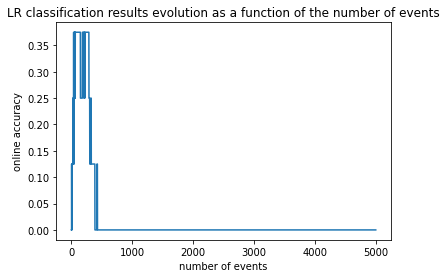

In [28]:
test_set, nb_pola, name_net = get_loader(name, record_path, nb_test, False, filt, tau, nbclust, sigma, homeinv, jitter, timestr, dataset, R, ds_ev = ds_ev_output)
pred_target, true_target = predict_data(test_set, model, nb_test, num_workers=num_workers)
mean_acc, online_acc = classification_results(pred_target, true_target, nb_test, verbose = True)